In [2]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib numpy scikit-learn seaborn

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached python_version-0.0.2-py2.py3-none-any.whl.metadata (1.7 kB)
Using cached python_version-0.0.2-py2.py3-none-any.whl (3.4 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\gandr\AppData\Local\Temp\pip-install-5uro7ed5\tensorflow-gpu_1cba84a1844c4cc2a4fb6f1a2b47d55f\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not buil

In [3]:
import tensorflow as tf
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
gpus

[]

In [10]:
data_dir = 'model/hand_data'
os.listdir(data_dir)


['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']

## Building data pipeline

In [11]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='int',  # Assuming integer-encoded labels
    image_size=(256, 256),  # Specify desired image size
    batch_size=32,  # Define batch size
    shuffle=True  # Shuffle the dataset
)

Found 36000 files belonging to 12 classes.


To access our data pipeline

In [12]:
data_iterator = data.as_numpy_iterator()

Accessing data pipeline

In [13]:
batch =data_iterator.next()
batch

(array([[[[1.84531250e+01, 4.05156250e+01, 2.95781250e+01],
          [3.29687500e+01, 4.94687500e+01, 4.10937500e+01],
          [4.84843750e+01, 6.61406250e+01, 5.90156250e+01],
          ...,
          [2.26562500e+00, 4.09843750e+01, 3.71093750e+01],
          [7.25000000e+00, 4.33437500e+01, 4.03281250e+01],
          [1.82812500e+00, 3.35468750e+01, 2.91093750e+01]],
 
         [[3.59531250e+01, 5.76093750e+01, 5.16875000e+01],
          [2.64375000e+01, 4.46875000e+01, 4.15625000e+01],
          [5.29218750e+01, 7.11718750e+01, 6.80468750e+01],
          ...,
          [3.43750000e-01, 3.81875000e+01, 2.95000000e+01],
          [2.03125000e+00, 3.02187500e+01, 2.42812500e+01],
          [7.81250000e-02, 1.61250000e+01, 1.05781250e+01]],
 
         [[2.69062500e+01, 4.85312500e+01, 4.59218750e+01],
          [3.75312500e+01, 5.58281250e+01, 5.31562500e+01],
          [5.54062500e+01, 7.37031250e+01, 6.95312500e+01],
          ...,
          [0.00000000e+00, 2.92500000e+01, 1.6921

In [14]:
len(batch)

2

Images represented as np arrays, 0 is the image, 1 is the class

In [15]:
batch[0].shape

(32, 256, 256, 3)

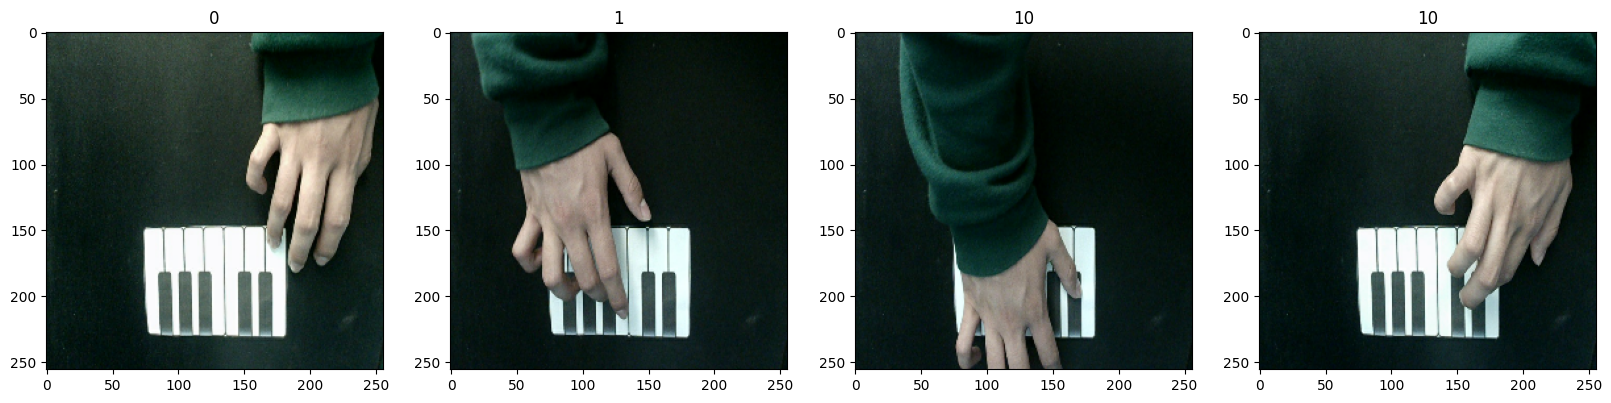

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocessing
map function allows us to preprocess data while it is passing trough data pipeline

In [21]:
data = data.map(lambda x,y: (x/255, y))


In [22]:
scaled_iterator = data.as_numpy_iterator()

In [23]:
batch = scaled_iterator.next()


In [24]:
batch[0].max()

1.0

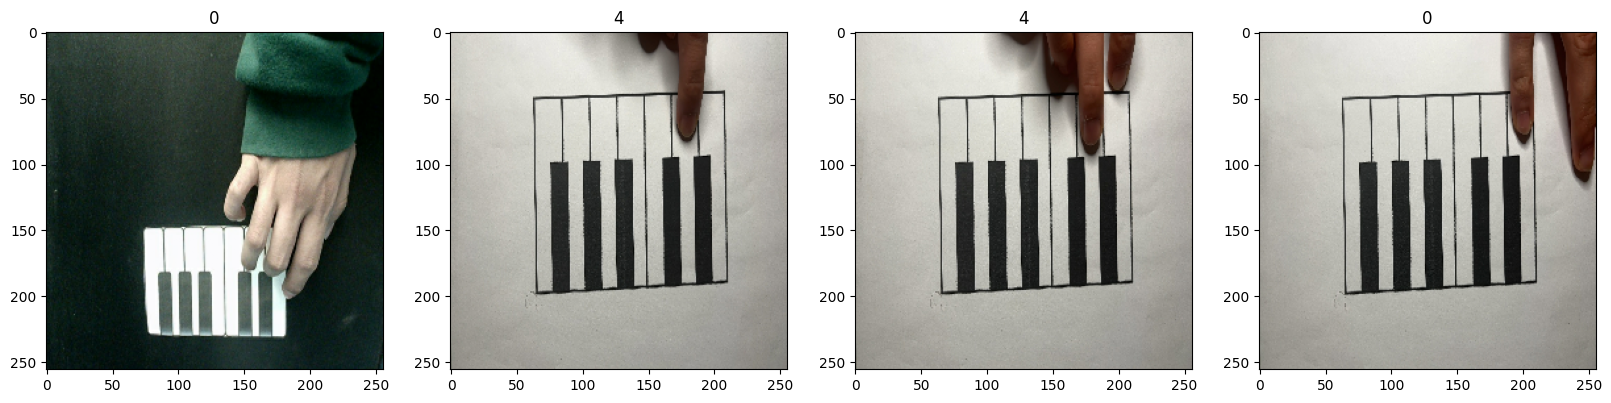

In [25]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

## Split Model

In [26]:
len(data)

1125

In [27]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [28]:
train_size + val_size +test_size

1125

In [29]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

## CNN model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import regularizers

In [33]:
model = Sequential()

# model.add(tf.keras.layers.RandomRotation(factor=0.2, input_shape=(256, 256, 3)))  # Random rotation (max 20% rotation angle)
model.add(tf.keras.layers.RandomContrast(factor=0.2, input_shape=(256, 256, 3)))  # Random contrast adjustment (max 20% contrast change)
# model.add(tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2))  # Random zoom (max 20% zoom)
# model.add(tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2))  # Random translation (max 20% shift)

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))

model.add(Dense(12, activation ='softmax'))

In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_contrast_1               │ (None, 256, 256, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,587,788 (112.87 MB)

 Trainable params: 29,587,788 (112.87 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [37]:

history = model.fit(train, epochs=10,
                    validation_data=val,
                    callbacks=[tensorboard_callback])

Epoch 1/10


c:\Users\gandr\Documents\vsproj\GitHub\PDS-Piano\.venv\lib\site-packages\keras\src\backend\tensorflow\nn.py:599: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


787/787 ━━━━━━━━━━━━━━━━━━━━ 867s 1s/step - accuracy: 0.4959 - loss: 3.8782 - val_accuracy: 0.8751 - val_loss: 0.9799
Epoch 2/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 835s 1s/step - accuracy: 0.8537 - loss: 0.9712 - val_accuracy: 0.9440 - val_loss: 0.6562
Epoch 3/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 781s 992ms/step - accuracy: 0.8813 - loss: 0.8060 - val_accuracy: 0.9457 - val_loss: 0.6333
Epoch 4/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 782s 993ms/step - accuracy: 0.9072 - loss: 0.7011 - val_accuracy: 0.9640 - val_loss: 0.5185
Epoch 5/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 802s 1s/step - accuracy: 0.9141 - loss: 0.6614 - val_accuracy: 0.9654 - val_loss: 0.5841
Epoch 6/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 780s 991ms/step - accuracy: 0.9190 - loss: 0.6346 - val_accuracy: 0.9588 - val_loss: 0.5300
Epoch 7/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 782s 993ms/step - accuracy: 0.9260 - loss: 0.6081 - val_accuracy: 0.9778 - val_loss: 0.4603
Epoch 8/10
787/787 ━━━━━━━━━━━━━━━━━━━━ 782s 993ms/step - accuracy: 0.9287 - loss: 0.5846 - val_

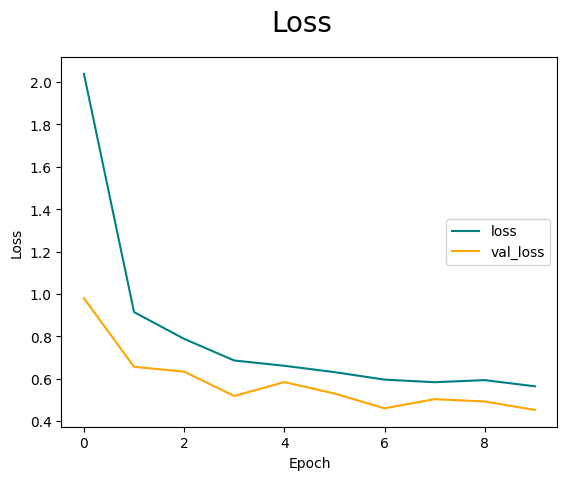

In [38]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color = 'orange', label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.suptitle('Loss', fontsize=20)
plt.legend(loc='right')
plt.show()



113/113 - 59s - 521ms/step - accuracy: 0.9831 - loss: 0.4513
0.9831305146217346


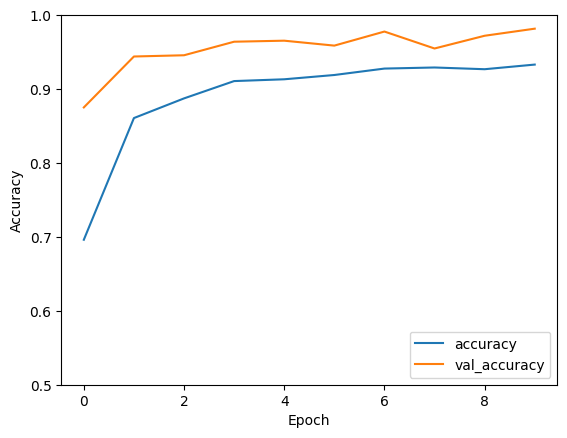

In [39]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test, verbose=2)

print(test_acc)

### Evaluation Metrics

In [40]:
from sklearn.metrics import accuracy_score

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through each batch in the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    
    # Predict the output labels for the input images
    yhat = model.predict(X)
    
    # Convert predicted probabilities to class labels
    predicted_batch_labels = yhat.argmax(axis=1)
    predicted_labels.extend(predicted_batch_labels)
    
    # Extend true_labels directly with class indices
    true_labels.extend(y)
    
    # Print intermediate results for debugging
    print("Batch True Labels:", y)
    print("Batch Predicted Labels:", predicted_batch_labels)

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print("Overall Test Accuracy:", overall_accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
Batch True Labels: [10  9 11  8  8  6 11 10  3  6  4  9  4  8  1  2  4  3  0  4  7  6  0  7
  3  2  6 11  6  3  3  9]
Batch Predicted Labels: [10  9 11  8  8  6 11 10  3  6  4  9  4  8  1  2  4  3  0  4  7  6  0  7
  3  2 11 11  6  3  3  9]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Batch True Labels: [ 3  8 10 11  8  7  1 11  2  4  1  7 10  9  1  0 10 10 11  2  7 11  8  7
  5  0  0 11  4  4  3 10]
Batch Predicted Labels: [ 3  8 10 11  8  7  1 11  2  4  1  7 10  9  1  0 10 10 11  2  7 11  8  7
  5  0  0 11  4  4  3 10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Batch True Labels: [ 2  9  5  8  2  7  1  6  1  4  5  4  5  4  3  8  7 10 10  2  8  4  7  6
  9  7 10 10  8  8  6  7]
Batch Predicted Labels: [ 2  9  5  8  2  7  1  6  1  4  5  4  5  4  3  8  7 10 10  2  8  4  7  6
  9  7 10 10  8  8  6  7]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Batch True Labels: [ 8  1  8 11 10  1  2  8  1  1  0  1  8  6  4  7  9 10  6  6  7 11 10  6
  8  9  3  2 11  3 11  6]
Bat

In [41]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


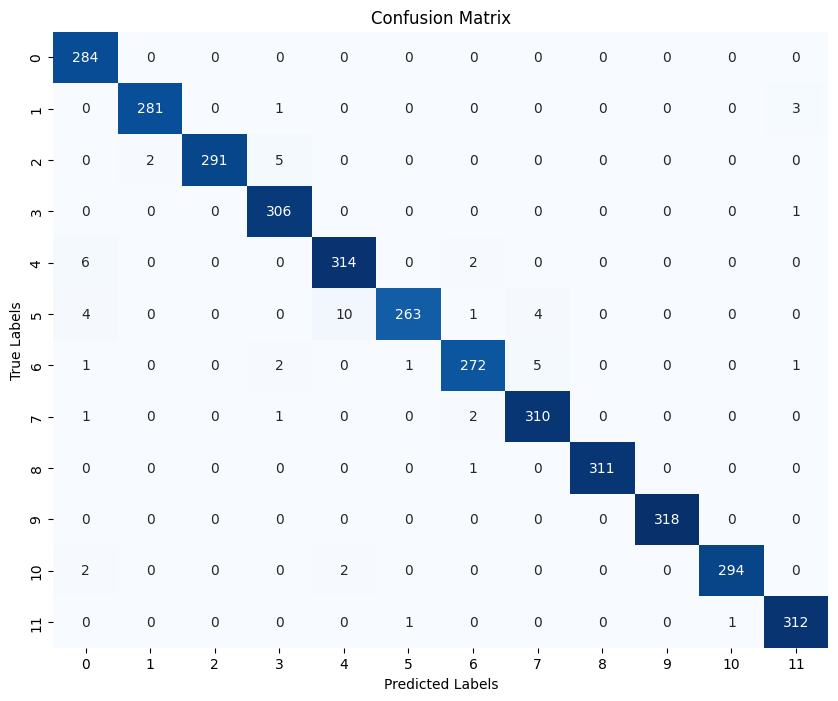

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [43]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='macro')  # You can use other averaging methods as well
print("Precision:", precision)

Accuracy: 0.9834070796460177


NameError: name 'precision_score' is not defined

Number of predictions:  3616


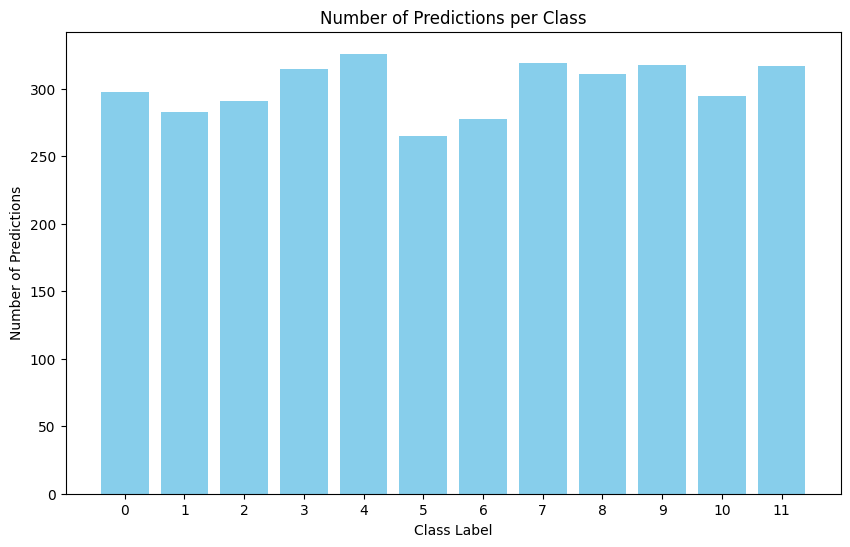

In [44]:
import matplotlib.pyplot as plt

# Count the occurrences of each predicted label
predicted_counts = {}
for label in predicted_labels:
    if label in predicted_counts:
        predicted_counts[label] += 1
    else:
        predicted_counts[label] = 1

# Sort the predicted counts by class label
sorted_predicted_counts = sorted(predicted_counts.items())

# Extract labels and counts
labels, counts = zip(*sorted_predicted_counts)

print('Number of predictions: ', len(predicted_labels))

# Plot the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Predictions')
plt.title('Number of Predictions per Class')
plt.xticks(labels)
plt.show()


In [45]:
from sklearn.metrics import classification_report

# Calculate classification report
class_report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       284
           1       0.99      0.99      0.99       285
           2       1.00      0.98      0.99       298
           3       0.97      1.00      0.98       307
           4       0.96      0.98      0.97       322
           5       0.99      0.93      0.96       282
           6       0.98      0.96      0.97       282
           7       0.97      0.99      0.98       314
           8       1.00      1.00      1.00       312
           9       1.00      1.00      1.00       318
          10       1.00      0.99      0.99       298
          11       0.98      0.99      0.99       314

    accuracy                           0.98      3616
   macro avg       0.98      0.98      0.98      3616
weighted avg       0.98      0.98      0.98      3616



### Exporting the model

In [1]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('model','pianoHand.h5'))

### How to load it

In [4]:
os.path.join('model','pianoHand.h5')

'model\\pianoHand.h5'

In [5]:
new_model = load_model(os.path.join('model','pianoHand.h5'))
# predict = new_predict(X)

In [6]:
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_contrast_1               │ (None, 256, 256, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,587,790 (112.87 MB)

 Trainable params: 29,587,788 (112.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [7]:
import os
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np


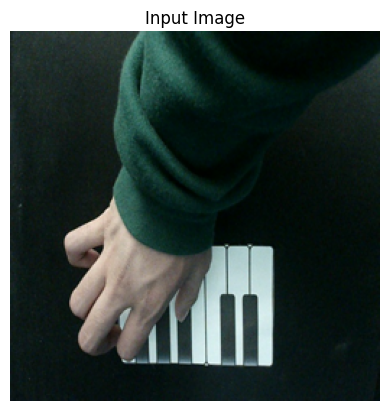

In [8]:
# Define the target input dimensions expected by your model
input_width, input_height = 256, 256  

# Load the image using PIL (Pillow)
image_path = os.path.join('model', 'hand_data', '10', '1501.jpg')
image = Image.open(image_path)

# Resize the image to match the input dimensions of the model
image = image.resize((input_width, input_height))

# Convert the image to a numpy array and normalize pixel values
image_array = np.array(image) / 255.0  # Normalize pixel values to [0, 1]

# Expand the dimensions of the image array to match the input shape expected by the model
input_data = np.expand_dims(image_array, axis=0)

# Display the image using matplotlib
plt.imshow(image_array)
plt.title('Input Image')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [9]:
# Perform inference using the loaded model
predictions = new_model.predict(input_data)

# Assuming a classification task with softmax output, get the predicted class
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Display the predicted class index
print("Predicted Class Index:", predicted_class_index)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Predicted Class Index: 1
